# Developing a machine learning strategy

**Goal: Research and validate models for predicting whether a Kickstarter project will be funded based on the campaign.** 

## Table of contents
1. [Loading the data](#cell1)
2. [Building the design matrix for meta features](#cell2)
3. [Building a design matrix for the $n$-gram model](#cell3)
4. [Preparing the target variable](#cell4)
5. [Evaluating models](#cell5)
7. [Diagnosing the classifier](#cell6)
8. [Using nested cross-validation to optimize hyperparameters](#cell7)
9. [Training a validated model](#cell8)
10. [Determining the top predictors of funded projects](#cell9)
11. [Testing Kickstarter pages](#cell10)

<a id="cell1"></a>
## 1. Loading the data

In [1]:
# Load required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import nltk
import feature_engineering
from scipy import sparse
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (
    learning_curve, StratifiedShuffleSplit, cross_val_score, ShuffleSplit,
    cross_val_predict, RandomizedSearchCV
)

# Set figure display options
%matplotlib inline
sns.set(context='notebook', style='darkgrid')
sns.set(font_scale=1.3)

The training set for both campaign sections are stored in PostgreSQL databases. Let's begin by loading the credentials to connect to the databases.

In [2]:
# Set database credentials
db_name1 = 'section1_db'
db_name2 = 'section2_db'
usernm = 'redwan'
host = 'localhost'
port = '5432'
#pwd = ''

Next we'll query all the data for both campaign sections and store them locally.

In [3]:
# Connect to database containing the "About this project" section
con1 = psycopg2.connect(
    database=db_name1, 
    host='localhost',
    user=usernm,
    password=pwd
)

# Connect to database containing the "Risks and challenges" section
con2 = psycopg2.connect(
    database=db_name2, 
    host='localhost',
    user=usernm,
    password=pwd
)

# Query all data from both campaign sections
sql_query1 = 'SELECT * FROM section1_db;'
sql_query2 = 'SELECT * FROM section2_db;'
section1_df_full = pd.read_sql_query(sql_query1, con1)
section2_df_full = pd.read_sql_query(sql_query2, con2)

### Regression vs. classification

We can either approach this problem as a classification task and attempt to predict whether a project will be funded or not. Another option is to predict what % of the goal will the project reach and therefore, approach the problem as a regression task. 

Let's start with the latter since it's more interesting. We'll begin by defining a new target variable `percent_funded` to compute what % of the goal was reached for each project.

In [4]:
# Define a target variable for regression
section1_df_full['percent_funded'] = section1_df_full['pledged'] / \
    section1_df_full['goal']

# Display a few rows
section1_df_full.head(2)

,level_0,index,num_sents,num_words,num_all_caps,percent_all_caps,num_exclms,percent_exclms,num_apple_words,percent_apple_words,...,normalized_text,name,category,hyperlink,currency,pledged,goal,location,funded,percent_funded
0,0,88389,15.0,223.0,0.0,0.0,3.0,0.013453,0.0,0.0,...,I am a numbr year old woman who was a general ...,Help me start my cottage industry ... Bakesale...,Small Batch,https://www.kickstarter.com/projects/138529431...,USD,0.0,10000.0,"Cape Coral, FL",False,0.000000
1,1,190378,15.0,383.0,0.0,0.0,4.0,0.010444,0.0,0.0,...,What happens to a sock that disappears in the ...,The Sock Who Lost His Mate at NY Children's Th...,Musical,https://www.kickstarter.com/projects/987315242...,USD,2600.0,7000.0,"Greenwich Village, Manhattan, NY",False,0.371429


<a id="cell2"></a>
## 2. Building the design matrix for meta features

Let's use the extracted meta features for the "About this project" section for now.

In [5]:
# List of meta features to use in models
features = ['num_sents', 'num_words', 'num_all_caps', 'percent_all_caps',
            'num_exclms', 'percent_exclms', 'num_apple_words',
            'percent_apple_words', 'avg_words_per_sent', 'num_paragraphs',
            'avg_sents_per_paragraph', 'avg_words_per_paragraph',
            'num_images', 'num_videos', 'num_youtubes', 'num_gifs',
            'num_hyperlinks', 'num_bolded', 'percent_bolded']

# Select meta features from the dataset
X = section1_df_full[features]

# Display the first five rows of the design matrix
X.head()

,num_sents,num_words,num_all_caps,percent_all_caps,num_exclms,percent_exclms,num_apple_words,percent_apple_words,avg_words_per_sent,num_paragraphs,avg_sents_per_paragraph,avg_words_per_paragraph,num_images,num_videos,num_youtubes,num_gifs,num_hyperlinks,num_bolded,percent_bolded
0,15.0,223.0,0.0,0.000000,3.0,0.013453,0.0,0.000000,14.866667,9.0,1.888889,24.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,15.0,383.0,0.0,0.000000,4.0,0.010444,0.0,0.000000,25.533333,5.0,3.000000,76.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,15.0,259.0,17.0,0.065637,0.0,0.000000,1.0,0.003861,17.266667,17.0,0.823529,11.470588,15.0,0.0,0.0,0.0,8.0,0.0,0.000000
3,18.0,431.0,0.0,0.000000,3.0,0.006961,1.0,0.002320,23.944444,3.0,6.000000,143.666667,0.0,0.0,0.0,0.0,2.0,0.0,0.000000
4,23.0,282.0,2.0,0.007092,15.0,0.053191,0.0,0.000000,12.260870,5.0,4.600000,56.600000,1.0,0.0,0.0,0.0,0.0,12.0,0.042553


### Data wrangling

Some of the projects may contain missing values. We need to decide how to deal with these projects since models in Scikit-learn cannot interpret them.

One strategy is to first remove all projects that have no data. These projects are most likely those that didn't include "About this project" section and can safely be excluded.

In [6]:
# Remove all rows with no data
X_cleaned = X[~X.isnull().all(axis=1)]

The remaining missing values arise as a result of missing data or if there is absolutely no text in the campaign. In the case of the latter, I had avoided a `DivisionByZeroError` when computing certain features, such as average words per sentence, where the number of sentences would be zero, by setting the number of sentences to `NaN` instead of zero. Therefore, setting these missing values now to zero is sensible.

In [7]:
# Fill remaining missing values with zero
X_cleaned = X_cleaned.fillna(0)

### Considering the "Risks and challenges" section

Not all Kickstarter projects have a "Risks and challenges" section. Let's determine what proportion of projects this is by defining a new feature called `risks_present` that computes and stores a value of 1 if the section is present, otherwise a 0. 

In [8]:
# Identify projects missing a "Risks and challenges" section
section2_df_full['risks_present'] = ~section2_df_full['normalized_text'] \
    .isnull()

# Select the projects missing a "Risks and challenges" section from the table
# containing the "About this projects" section
section1_df_full = section1_df_full.merge(
    section2_df_full[['index', 'risks_present']],
    how='left', 
    on='index'
)

# Compute the proportion of projects missing a "Risks and challenges" section
(len(section1_df_full) - section1_df_full['risks_present'].sum()) / \
    len(section1_df_full)

0.22762439938105708

That's concerning&mdash;nearly 23% of projects are missing a "Risks and challenges" section. Let's compare this to the number of projects missing an "About this project" section.

In [9]:
# Compute the proportion of projects missing an "About this projects" section
(len(section1_df_full) - len(X_cleaned)) / len(section1_df_full)

0.0012623177783207102

It looks like nearly every project has an "About this project" section. After some digging, I discovered that the "Risks and challenges" became mandatory only a few years ago. Therefore, I've elected to not include the "Risks and challenges" section in the feature space for two reasons:

1. A large proportion of the projects is missing the "Risks and challenges" section, which may skew the remaining projects that *do* contain this section
2. There have been many successful projects in the past that didn't have this section (as it wasn't required) such as the original [Pebble watch](https://www.kickstarter.com/projects/getpebble/pebble-e-paper-watch-for-iphone-and-android/description)

### Standardizing the meta features

Most machine learning models, besides tree-based models, only function if the features are standardized to have zero mean and unit variance, while others will converge faster. Therefore, let's go ahead and standardize the meta features.

In [10]:
# Standardize the meta features
scaler = StandardScaler()
X_std = scaler.fit_transform(X_cleaned)

<a id="cell3"></a>
## 3. Building a design matrix for the $n$-gram model

We can use the normalized text data from each project's "About this project" section to build an $n$-gram model to determine the specific words or pairs of words that are most predictive of funded projects. These contextual data may improve the model's performance when combined with the meta features.

It's possible that the $n$-gram model might pick up noise or convey irrelevant information because they probe into the context of the campaign section, which likely includes terms specifically linked to the project category. However, building a tailored model for the 100+ categories will be tedious and not feasible here. Nevertheless, to build the $n$-gram model, we'll need to perform some additional preprocessing.

1. Remove punctuation
2. Lowercase the text
3. Remove stop words
4. Stem remaining words

In [11]:
def preprocess_text(text):
    """Perform text preprocessing such as removing punctuation, lowercasing all
    words, removing stop words and stemming remaining words
    
    Args:
        text (str): cleaned and normalized text of a campaign section
    
    Returns:
        a string containing text that has been preprocessed"""
    
    # Access stop word dictionary
    stop_words = set(nltk.corpus.stopwords.words('english'))

    # Prepare the Porter stemmer
    porter = nltk.PorterStemmer()
    
    # Remove punctuation and lowercase each word
    text = feature_engineering.remove_punc(text).lower()
    
    # Remove stop words and stem each word
    return ' '.join(
        porter.stem(term )
        for term in text.split()
        if term not in stop_words
    )

Let's go ahead and preprocess the campaign section for each project.

In [12]:
# Perform preprocessing
#preprocessed_text = section1_df_full.loc[X_cleaned.index, 'normalized_text'] \
#    .apply(preprocess_text)

# Alternatively load a pickle that contains the already preprocessed text 
preprocessed_text = joblib.load('data/nlp/preprocessed_text_training_set.pkl')

For the $n$-gram model, I've elected to use unigrams and bigrams quantified using the tf-idf statistic and then selecting the top 250 features measured by term frequency. The reason for fewer $n$-grams is to a) minimize the risk of overfitting and b) prevent the model from having too much contextual data when making a prediction, which is harder for the creator's to tweak in their projects. 

In [13]:
# Construct a design matrix using an n-gram model and tf-idf statistics
#vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=250)
#X_ngrams = vectorizer.fit_transform(preprocessed_text)
#joblib.dump(vectorizer, 'vectorizer_250.pkl')
#joblib.dump(X_ngrams, 'X_ngrams_250.pkl')

# Alternatively we can load a pickle that contains the already constructed 
# n-grams and vectorizer
X_ngrams = joblib.load('data/nlp/X_ngrams_250.pkl')
vectorizer = joblib.load('data/nlp/vectorizer_250.pkl')

### Combining meta features with $n$-grams

Since the meta features are housed in a Numpy array while the $n$-grams are inside a Scipy sparse matrix, we need to convert the former into a sparse matrix and then concatenate all the features together.

In [14]:
# Convert the meta features into a sparse matrix
X_std_sparse = sparse.csr_matrix(X_std)

# Concatenate the meta features with the n-grams
X_full = sparse.hstack([X_std_sparse, X_ngrams])

# Display the shape of the combined matrix for confirmation
X_full.shape

(24527, 269)

<a id="cell4"></a>
## 4. Preparing the target variable

Let's select all rows of the regression target variable `percent_funded` that correspond to the rows in the cleaned design matrix.

In [15]:
# Prepare the regression target variable
y_reg = section1_df_full.loc[X_cleaned.index, 'percent_funded'].to_frame()

Since some of the regression models expect the target variable to be normally distributed, let's take a look at the distribution of `percent_funded`.

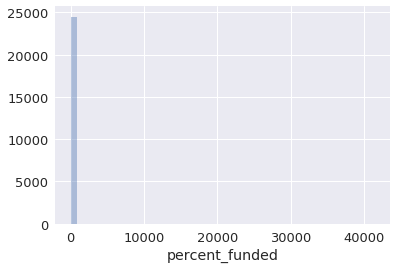

In [16]:
# Display a histogram of the regression target variable
sns.distplot(y_reg['percent_funded'], kde=False);

The histogram is clearly skewed to the right, meaning we have some outliers. Let's zoom in on the left side.

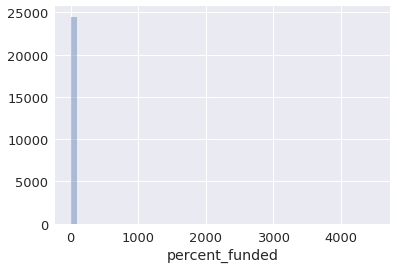

In [17]:
# Display a kde plot of the regression target variable
sns.distplot(
    y_reg[y_reg['percent_funded'] < 5000]['percent_funded'],
    kde=False
);

That's still not enough&mdash;let's zoom in further.

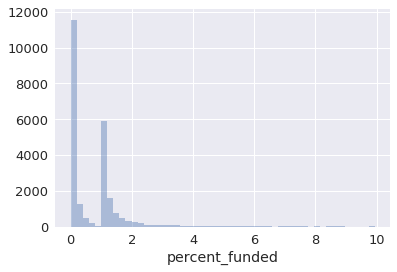

In [18]:
# Display a kde plot of the regression target variable
sns.distplot(
    y_reg[y_reg['percent_funded'] < 10]['percent_funded'],
    kde=False
);

Clearly, the regression target variable has a multi-modal distribution. About 50% of the projects raise little to no funding, while about 25% of the projects almost reach their funding goal. The remaining 25% are funded projects but are very spread out.

We clearly can't apply standard regression techniques on the regression target variable. One option would be to separate the two distributions, label them and then perform classification. However, not only would we lose a lot of information, we'd lose the remaining 25% of the data that isn't found in the bimodal distribution. This seems like a risky proposition; therefore, let's avoid regression and turn to a pure classification approach.

### Encoding the target variable for classification

For classification tasks, the models in Scikit-learn will work only if the classification target variable is encoded numerically. To do so, let's first select all rows of `funded` that correspond to the rows in the cleaned design matrix.

In [19]:
# Prepare the classification target variable
y = section1_df_full.loc[X_cleaned.index, 'funded'].to_frame()

Before encoding the classification target variable, let's take a peek at the class distribution.

In [20]:
# Display the class distribution
y['funded'].value_counts()

False    13894
True     10633
Name: funded, dtype: int64

The funded projects are distributed about 3 to 7, which is just slightly imbalanced. We'll keep this mind when choosing a performance metric. Finally, let's encode the target variable.

In [21]:
# Encode the class labels in the target variable
le = LabelEncoder()
y_enc = le.fit_transform(y.values.ravel())

<a id="cell5"></a>
## 5. Evaluating models

We'll approach the modeling with Occam's razor in mind and start with those models that are
- parametric - fast to train, less prone to overfitting
- linear - text-based data is typically linearly separable
- explainable - it's preferable for the creator to understand what's going on under the hood

As a starting point, we'll only train a model on the meta features. Out of curiosity, let's see how an ordinary least squares regression using stochastic gradient descent (SGD) performs on the dataset as it stands, using the correlation of determination $R^2$ as the performance metric. We'll use a randomized 10-fold cross-validation strategy with a 80/20 training/test set split in each fold. 

For the number of iterations in SGD, let's use the recommended number from Scikit-learn's [documentation](http://scikit-learn.org/stable/modules/sgd.html#sgd).

In [22]:
# Set the recommended number of iterations for SGD
SGD_iterations = np.ceil(10 ** 6 / len(X_std))
SGD_iterations

41.0

In [23]:
# Compute cross-validated precision scores for an OLS regression
scores = cross_val_score(
    estimator=SGDRegressor(max_iter=SGD_iterations, random_state=41),
    X=X_std,
    y=y_reg.values.ravel(),
    cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='r2',
    n_jobs=-1
)

# Display the average and standard deviation of the cross-validation scores
print('R^2: {} +/- {}'.format(scores.mean(), scores.std()))

R^2: -0.23501800317182925 +/- 0.3114688648478518


We clearly see the model is unstable and inappropriate for this problem&mdash;a likely result of the bimodal distribution in the regression target variable. 

### Evaluating classifiers using only meta features

Let's start with logistic regression regularized by an elastic net and trained with SGD, and use the default hyperparameters. We'll use a randomized 10-fold cross-validation strategy with a 80/20 training/test set split in each fold. Because the classes are imbalanced, we need to incorporate stratification in the splitting process. 

Predicting that a project will be funded when it actually ends up not being funded (false positive) is a more egregious error than the opposite (false negative). A false positive may lead to a loss in credibility in the model; on the other hand, a false negative isn't a major concern&mdash;it's unlikely that any creator would abandon their painstaking efforts on their Kickstarter project after receiving an estimate from a single website! Therefore, we should aim to optimize precision, which focuses on false positives, and select this as the performance metric for classification.

In [24]:
# Compute cross-validated precision scores for logistic regression
scores = cross_val_score(
    estimator=SGDClassifier(
        loss='log',
        penalty='elasticnet',
        max_iter=SGD_iterations,
        random_state=41
    ),
    X=X_std,
    y=y_enc,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='precision',
    n_jobs=-1
)

# Display the average and standard deviation of the cross-validation scores
print('Precision: {} +/- {}'.format(scores.mean(), scores.std()))

Precision: 0.6381477285446968 +/- 0.024444364116648926


An precision score of 0.64 is a decent start, especially considering a dummy classifier using the class distribution can't beat 0.44. Let's see where the model is making mistakes using a normalized confusion matrix.

In [25]:
# Make cross-validated predictions for the training set
y_pred = cross_val_predict(
    estimator=SGDClassifier(
        loss='log',
        penalty='elasticnet',
        max_iter=SGD_iterations,
        random_state=41
    ),
    X=X_std,
    y=y_enc,
    n_jobs=-1
)

# Compute the confusion matrix
cm = metrics.confusion_matrix(y_enc, y_pred)

# Display a normalized confusion matrix
pd.DataFrame(
    np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2),
    index=[['actual', 'actual'], ['unfunded', 'funded']],
    columns=[['predicted', 'predicted'], ['unfunded', 'funded']]
)

predicted       
                 unfunded funded
actual unfunded      0.81   0.19
       funded        0.61   0.39

It looks like the the model does a great job with false positives, the primary concern. However, it does make a lot of false negatives. Again, these are less of a concern&mdash;it's acceptable if some projects that end up getting funded slip through the cracks. 

### Adding $n$-grams to the feature space

Let's see if incorporating $n$-grams into the feature space improves performance.

In [26]:
# Compute cross-validated precision scores for logistic regression
scores = cross_val_score(
    estimator=SGDClassifier(
        loss='log',
        penalty='elasticnet',
        max_iter=SGD_iterations,
        random_state=41
    ),
    X=X_full,
    y=y_enc,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='precision',
    n_jobs=-1
)

# Display the average and standard deviation of the cross-validation scores
print('Precision: {} +/- {}'.format(scores.mean(), scores.std()))

Precision: 0.696789117961657 +/- 0.007749993039365257


It looks like the precision jumps up a bit. Let's see what kind of mistakes are being made now that we included $n$-grams.

In [27]:
# Make cross-validated predictions for the training set
y_pred = cross_val_predict(
    estimator=SGDClassifier(
        loss='log',
        penalty='elasticnet',
        max_iter=SGD_iterations,
        random_state=41
    ),
    X=X_full,
    y=y_enc,
    n_jobs=-1
)

# Compute the confusion matrix
cm2 = metrics.confusion_matrix(y_enc, y_pred)

# Display a normalized confusion matrix
pd.DataFrame(
    np.round(cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis], 2),
    index=[['actual', 'actual'], ['unfunded', 'funded']],
    columns=[['predicted', 'predicted'], ['unfunded', 'funded']]
)

predicted       
                 unfunded funded
actual unfunded      0.78   0.22
       funded        0.36   0.64

By adding $n$-grams into the features, we've increased the false positive rate by 0.03, but improved the true positive rate and the false negative rate each by 0.25! The slight increase in false positive rate is definitely an acceptable trade-off&mdash;we'll continue onwards using both meta features and $n$-grams in the feature space. 

<a id="cell6"></a>
## 6. Diagnosing the classifier

### Computing learning curves to assess high variance

Because the model is performing relatively well prior to tuning the hyperparameters, let's examine whether the classifier is suffering from high variance and overfitting. We can assess this potential issue using learning curves.

In [28]:
# Select 10 different sizes of the complete dataset
sample_space = np.linspace(100, len(X_std) * 0.8, 10, dtype='int')

# Compute learning curves
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=SGDClassifier(
        loss='log',
        penalty='elasticnet',
        max_iter=SGD_iterations,
        random_state=41
    ),
    X=X_full,
    y=y_enc,
    train_sizes=sample_space,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='precision',
    n_jobs=-1
)

To display the learning curves, we'll need to transform the results into tidy format. Let's define a function that performs this transformation.

In [29]:
def make_tidy(sample_space, train_scores, valid_scores):
    """Transform a pivot-table-style dataset containing training and validation
    scores computed for plotting learning curves into tidy format where each 
    row is a training subset size and the columns are the specific training 
    subset sizes, training set scores, and validation set scores. This enables
    the data to be plotted with the Seaborn library.
    
    Args:
        sample_space (ndarray): a NumPy array of integers containing the
            sizes of the training subsets
        train_scores (ndarray): a NumPy array containing training set scores
            from 10 folds of cross-validation
        valid_scores (ndarray): a NumPy array containing validation set scores
            from 10 folds of cross-validation
    
    Returns:
        a Pandas DataFrame containing each training subset size and the mean
        training and validation score for each set size"""
    
    # Join train_scores and valid_scores, and label with sample_space
    messy_format = pd.DataFrame(
        np.stack((sample_space, train_scores.mean(axis=1),
                  valid_scores.mean(axis=1)), axis=1),
        columns=['# of training examples', 'Training set', 'Validation set']
    )
    
    # Re-structure table into into tidy format
    return pd.melt(
        messy_format,
        id_vars='# of training examples',
        value_vars=['Training set', 'Validation set'],
        var_name='Scores',
        value_name='precision'
    )

We're now ready to plot the learning curves.

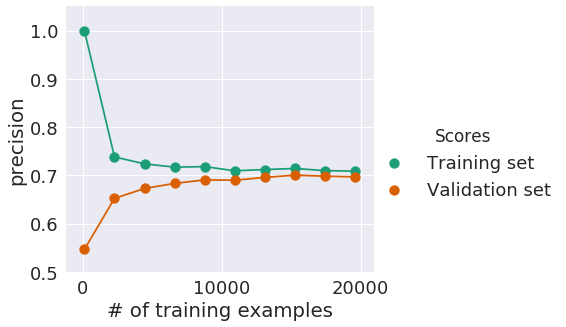

In [30]:
# Change the font scale
sns.set(font_scale=1.8)

# Initialize a FacetGrid object using the table of scores and facet on
# the score from the different sets
fig = sns.FacetGrid(
    make_tidy(sample_space, train_scores, valid_scores),
    hue='Scores',
    size=5,
    palette='Dark2',
    aspect=1.2
)

# Plot the learning curves, add a legend, and rescale y-axis
fig.map(plt.scatter, '# of training examples', 'precision', s=100)
fig.map(plt.plot, '# of training examples', 'precision') \
    .set(ylim=(0.5, 1.05), xticks=(0, 10000, 20000)) \
    .add_legend();

# Save the figure
#fig.savefig('learning_curves.png', dpi=300, bbox_inches='tight');

The learning curves converge quickly to a respectable precision score. This suggests the model isn't suffering from high variance and therefore, not overfitting. To tighten the curves more, we can try tuning the  hyperparameters.

<a id="cell7"></a>
## 7. Using nested cross-validation to optimize hyperparameters

We're now ready to tune the hyperparameters of the model: `l1_ratio` for the elastic net weighting and `alpha` for the degree of regularization. To do so without optimistically biasing the model and leaking information about the test set into the training set, let's utilize nested cross-validation.

In [31]:
# Initialize the hyperparameter space
param_dist = {
    'alpha': np.logspace(-6, -1, 50),
    'l1_ratio': np.linspace(0, 1, 50)
}

# Inner cross-validation loop to tune the hyperparameters
random_search = RandomizedSearchCV(
    estimator=SGDClassifier(
        loss='log',
        penalty='elasticnet',
        max_iter=SGD_iterations,
        random_state=41
    ),
    param_distributions=param_dist,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='precision',
    random_state=41,
    n_iter=40,
    n_jobs=-1
)

# Outer cross-validation loop to assess model performance
scores = cross_val_score(
    estimator=random_search,
    X=X_full,
    y=y_enc,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='precision'
)

# Display cross-validation scores
scores

array([ 0.70689655,  0.70256142,  0.68853363,  0.69846491,  0.71084337,
        0.70120614,  0.71214738,  0.70316843,  0.71139809,  0.715     ])

The scores across the different cross-validation folds don't vary much&mdash;this is a sign that the model is stable. Let's finish up by computing the average precision score and its standard deviation.

In [32]:
# Display the average precision score and its standard deviation
print('Precision: {} +/- {}'.format(scores.mean(), scores.std()))

Precision: 0.7050219925448211 +/- 0.007531939965661976


<a id="cell8"></a>
## 8. Training a validated model

Let's train a final model on the full training set to minimize pessimistic bias. However, we first must identify the optimal hyperparameters because nested cross-validation only evaluated performance but didn't report back the optimal hyperparameter values. Therefore, we must train the randomized hyperparameter search model on the training set to gain access to the optimal hyperparameters.

In [33]:
# Train the random hyperparameter search on the training set
random_search.fit(X_full, y_enc)

# Display the optimal hyperparameters
random_search.best_params_

{'alpha': 0.00091029817799152173, 'l1_ratio': 0.18367346938775508}

Let's use these optimal hyperparameter values and train a model on the full training set.

In [34]:
# Train the classifier on the full dataset using the optimal hyperparameters
final_clf = SGDClassifier(
        loss='log',
        penalty='elasticnet',
        alpha=random_search.best_params_['alpha'],
        l1_ratio=random_search.best_params_['l1_ratio'],
        max_iter=SGD_iterations,
        random_state=41
)
final_clf.fit(X_full, y_enc);

We can verify that the hyperparameter tuning was effective by re-plotting learning curves.

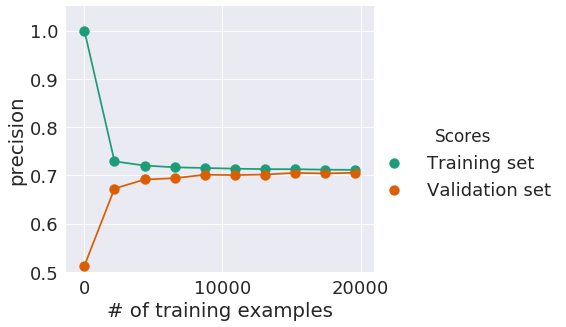

In [35]:
# Select 10 different sizes of the dataset
sample_space = np.linspace(15, len(X_std) * 0.8, 10, dtype='int')

# Compute learning curves
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=final_clf,
    X=X_full,
    y=y_enc,
    train_sizes=sample_space,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='precision',
    n_jobs=-1
)

# Initialize a FacetGrid object using the table of scores and facet on
# the score from the different sets
fig = sns.FacetGrid(
    make_tidy(sample_space, train_scores, valid_scores),
    hue='Scores',
    size=5,
    palette='Dark2',
    aspect=1.2
)

# Plot the learning curves, add a legend, and rescale y-axis
fig.map(plt.scatter, '# of training examples', 'precision', s=100)
fig.map(plt.plot, '# of training examples', 'precision') \
    .set(ylim=(0.5, 1.05), xticks=(0, 10000, 20000)) \
    .add_legend();

The learning curves are tighter&mdash;indeed, we have a well-performing model that isn't overfitting.

<a id="cell9"></a>
## 9. Determining the top predictors of funded projects

We can now examine the top features that were most predictive of funded projects.

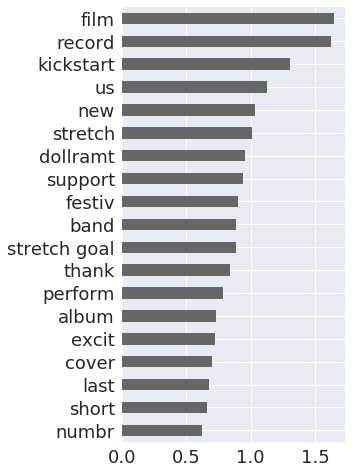

In [36]:
# Combine meta feature labels with n-gram labels
all_features = features + vectorizer.get_feature_names()

# Add the corresponding feature names to the parameters, sorted from highest
# to lowest
feature_ranks = pd.Series(
    final_clf.coef_.T.ravel(),
    index=all_features
).sort_values(ascending=False)[:19][::-1]

# Display a bar graph of the top features
graph = feature_ranks.plot(
    kind='barh',
    legend=False,
    figsize=(4, 8),
    color='#666666'
);

# Save the figure
#fig = graph.get_figure()
#fig.savefig('ngrams', dpi=300, bbox_inches='tight');

Clearly, there's a lot of $n$-grams linked to specific product categories but some are meaningful for creators:

- `dollramt` - This refers to dollar amounts found in the campaign section. Perhaps successful creators are reiterating the pledge awards.
- `stretch`, `stretch goal`, `support` - Referring to stretch goals seems to be a good idea
- `thank` - It looks like thanking the backers or readers is definitely advisable
- `excit` - This is likely the word stem of "exciting", which is an innovation word that I could've included in the list of innovation words

Since there were no meta features in the top features, let's examine them separately and see which meta features were the most predictive of funded projects.

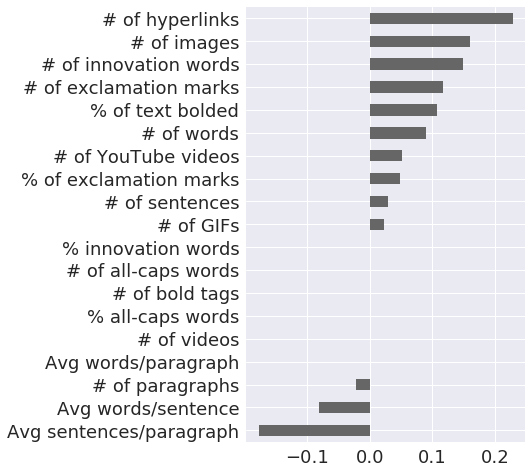

In [37]:
# Add the corresponding meta feature names to the parameters, sorted from
# highest to lowest
meta_feature_ranks = pd.Series(
    final_clf.coef_.T.ravel()[:len(features)],
    index=features
).sort_values(ascending=False)[::-1]

# Display a bar plot of the meta feature importance
graph2 = meta_feature_ranks.plot(
    kind='barh',
    legend=False,
    figsize=(5, 8),
    color='#666666'
)

# Change the meta feature labels from variables to names
labels = [
    '# of hyperlinks',
    '# of images',
    '# of innovation words',
    '# of exclamation marks',
    '% of text bolded', 
    '# of words',
    '# of YouTube videos',
    '% of exclamation marks',
    '# of sentences',
    '# of GIFs',
    '% innovation words',
    '# of all-caps words',
    '# of bold tags',
    '% all-caps words',
    '# of videos',
    'Avg words/paragraph',
    '# of paragraphs',
    'Avg words/sentence',
    'Avg sentences/paragraph'    
]
plt.yticks(np.arange(19), labels[::-1]);

# Save the figure
#fig2 = graph2.get_figure()
#fig2.savefig('meta', dpi=300, bbox_inches='tight');

It looks like the most predictive meta feature is the number of hyperlinks. Many successful projects were covered by the news media and their creators likely decided to include the hyperlinks to those articles in their campaigns. In addition, it's not uncommon to use hyperlinks to build a "bibliography" to establish credibility. And my hypothesis about having innovation words was correct!

Meta features that serve to grab attention appeared as strong predictors: bolded text, exclamation marks, innovation words, and images. However, for bolded text, having a high proportion of bold text is better than hitting some absolute count, whereas for images, innovation words and exclamation marks, it's a good idea for creators to use them often! Finally, the length of the campaign, as determined by the number of words, was also a good predictor of success, which indirectly correlates to how much effort the creator spent on the campaign.

Surprisingly, all-caps words and GIFs weren't strong predictors. However, my regex for all-caps likely picked up abbreviations. For GIFs, perhaps they don't seem professional and fail to build credibility?

Some of the best ways to *not* get funded were to have too many sentences per paragraph or too many words per sentence. This is clearly hinting that writing succinctly is a good idea!

<a id="cell10"></a>
## 10. Testing Kickstarter pages

Let's engineer features for a sample Kickstarter page, such as the [Pebble 2](https://www.kickstarter.com/projects/getpebble/pebble-2-time-2-and-core-an-entirely-new-3g-ultra), and insert the prepared feature vector and target variable into the trained model to see how it evaluates a project that is known to be successful.

In [38]:
# Select a hyperlink
hyperlink = 'https://www.kickstarter.com/projects/getpebble/pebble' + \
    '-2-time-2-and-core-an-entirely-new-3g-ultra'

In [39]:
# Compute the meta features and preprocess the campaign section
meta_features, processed_section = feature_engineering.process_project(
    hyperlink
)

# Compute the n-grams from the preprocessed text
ngrams = vectorizer.transform([processed_section])

# Standardize the meta features and convert results into a sparse matrix
scaled_meta_features = sparse.csr_matrix(scaler.transform([meta_features]))

# Concatenate the meta features with the n-gram vector
feature_vector = sparse.hstack([scaled_meta_features, ngrams])

# Display the probability of being funded
final_clf.predict_proba(feature_vector)[0, 1]

0.96767312621135981